In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import copy
import logging
import os
import warnings
import IPython
from pathlib import Path

import matplotlib.pyplot as plt
import mplcursors
import music21
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from joblib import Parallel, delayed
import pytorch_lightning as pl
from tqdm.notebook import tqdm
# from tqdm import tqmm

from double_jig_gen.data import (
    ABCDataset,
    INFO_FIELD_PATTERN,
    TOKEN_SEPARATOR,
    clean_and_standardise_token,
    default_pad_batch,
    fix_encoding_errors,
    get_oneills_dataloaders,
    get_folkrnn_dataloaders,
    remove_quoted_strings,
)
from double_jig_gen.models import SimpleRNN
from double_jig_gen.tokenizers import Tokenizer, ABCTune, ABCTuneError
from double_jig_gen.utils import get_model_from_checkpoint

logging.basicConfig()
LOGGER = logging.getLogger(__name__)
LOGGER.setLevel("DEBUG")

In [3]:
! nvidia-smi

Fri Jul 16 05:16:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 31%   47C    P2    88W / 250W |   2574MiB / 11019MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 24%   

In [13]:
DEVICE_ID = 7
SCRATCH_NAME = "scratch_ssd"
DATA_HOME = f"/disk/{SCRATCH_NAME}/s0816700/data"
# INPUT_DATA_PATH = f"{DATA_HOME}/raw/folk-rnn/data_v1"
# TOKENIZED_DATA_PATH = f"{DATA_HOME}/working/folk-rnn/clean-folk-rnn_100.txt"
# TOKENIZED_DATA_PATH = f"{DATA_HOME}/working/folk-rnn/clean-folk-rnn.txt"
TOKENIZED_DATA_PATH = f"{DATA_HOME}/working/thesession.org/tokenized_tunes.txt"

In [14]:
# ! scripts/dj-gen-download-folkrnn {DATA_HOME}
# ! echo scripts/dj-gen-tokenize-abc --data-path {INPUT_DATA_PATH} --output-path {TOKENIZED_DATA_PATH} --log-level INFO

In [15]:
# ! scripts/dj-gen-tokenize-abc --data-path /disk/scratch_ssd/s0816700/data/raw/folk-rnn/data_v1 --output-path /disk/scratch_ssd/s0816700/data/working/folk-rnn/clean-folk-rnn_1000.txt --nr-tunes 1000 --log-level INFO

In [16]:
# https://github.com/IraKorshunova/folk-rnn/blob/master/configurations/config5.py
ONE_HOT = True
EMBEDDING_SIZE = 256  # is ignored if one_hot=True
NUM_LAYERS = 3
RNN_SIZE = 512
DROPOUT = 0.5

LEARNING_RATE = 0.003
LEARNING_RATE_DECAY_AFTER = 20
LEARNING_RATE_DECAY = 0.97

BATCH_SIZE = 256
MAX_EPOCH = 100
GRAD_CLIPPING = 5
VALIDATION_FRACTION = 0.05
VALIDATE_EVERY = 1000  # iterations

SAVE_EVERY = 10  # epochs

In [17]:
LOGGER.info(f"Changing to device {DEVICE_ID}")
os.environ["CUDA_VISIBLE_DEVICES"] = f"{DEVICE_ID}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOGGER.info(f"device = {device}")

INFO:__main__:Changing to device 7
INFO:__main__:device = cuda


In [18]:
user_settings = music21.environment.UserSettings()
user_settings["lilypondPath"] = "/afs/inf.ed.ac.uk/user/s08/s0816700/bin/lilypond"
# user_settings["lilypondPath"] = "/afs/inf.ed.ac.uk/user/s08/s0816700/bin/lilypond-xvfb-run"
# user_settings["lilypondPath"] = "/afs/inf.ed.ac.uk/user/s08/s0816700/bin/lilypond_original"
# user_settings["lilypondPath"] = "/afs/inf.ed.ac.uk/user/s08/s0816700/lilypond/usr/bin/lilypond"

In [19]:
user_settings["lilypondPath"]

PosixPath('/afs/inf.ed.ac.uk/user/s08/s0816700/bin/lilypond')

In [20]:
user_settings['showFormat'] = "lilypond"

# Read FolkRNN data

In [21]:
with open(TOKENIZED_DATA_PATH, "r") as fh:
    tunes_as_str = [line.strip() for line in fh.readlines()]
len(tunes_as_str)

41939

In [22]:
with open(TOKENIZED_DATA_PATH, "r") as fh:
    tunes_as_token_lists = [line.strip().split(TOKEN_SEPARATOR) for line in fh.readlines()]

In [23]:
len(tunes_as_token_lists)

41939

# Rare tokens

In [24]:
token_counts = pd.Series(
    [
        tok
        for tune in tunes_as_token_lists
        for tok in tune
    ]
).value_counts()
token_counts.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

In [25]:
len(token_counts)

1562

In [26]:
# min_freq = 2
# is_removed = token_counts < min_freq
# removed_tokens = token_counts[is_removed].index
# nr_removed_tokens = sum(is_removed)
# removed_tunes = [
#     tune for tune in tunes_as_token_lists if any(token in removed_tokens for token in tune)
# ]
# nr_removed_tunes = len(removed_tunes)
# print(f"{nr_removed_tokens=}, {nr_removed_tunes=}")
# pd.Series(
#     [
#         tok
#         for tune in tunes_as_token_lists
#         for tok in tune
#         if tok not in removed_tokens
#     ]
# ).value_counts().plot()

In [27]:
# low = len(token_counts) - nr_removed_tokens
# hi = len(token_counts) - nr_removed_tokens + 100
# token_counts.iloc[low:hi].plot()

In [28]:
search_str = "~"
token_counts[[idx for idx in token_counts.index if search_str in idx]]

Series([], dtype: int64)

In [29]:
search_str = "("
token_counts[
    [
        idx for idx in token_counts.index
        if search_str in idx and not INFO_FIELD_PATTERN.match(idx)
    ]
]

(3                                                                                          55856
(                                                                                           16450
(4                                                                                            152
(2                                                                                             62
(3:2:1                                                                                         30
(3:2:2                                                                                         24
(5                                                                                             14
(3:1:3                                                                                          6
(4:4:4                                                                                          5
(3:2:5                                                                                          5
(3::4               

In [30]:
search_str = "//"
list(token_counts[
    [
        idx for idx in token_counts.index
        if idx.endswith(search_str)
    ]
].index)

[]

In [31]:
search_str = "m:"
token_counts[[idx for idx in token_counts.index if search_str in idx]]

Series([], dtype: int64)

In [32]:
search_str = "."
token_counts[[idx for idx in token_counts.index if search_str in idx]]

.           6689
^.G2           7
[.d2.f2]       3
[A2.f2]        3
dtype: int64

In [33]:
token_counts[[idx for idx in token_counts.index if len(idx) > 1 and idx[1] == ":"]]

|:                                                                                          53075
L:1/8                                                                                       41945
T:tune title                                                                                41933
R:rhythm                                                                                    41933
X:reference number                                                                          41933
                                                                                            ...  
K:ALyd                                                                                          2
M:4/2                                                                                           2
|: d2 de dc A2 | (3Bcd ed cA G2 |[1 Adde dcAB | cAGE EDFA :|[2 Adde f2 ed | cAGE EDAF |]        2
|: ef/e/ ce | fe a2 | ef/e/ ce | fe c/B/A |                                                     2
M:3/8               

In [34]:
token_counts[[idx for idx in token_counts.index if len(idx) > 2 and idx[2] == ":"]]

[M:4/4]     288
[M:3/4]     271
[M:2/4]     233
[M:6/8]     202
[M:9/8]     139
           ... 
[K:Dmaj]      1
[P:A]         1
[K:Dmin]      1
[K:Ddor]      1
[K: D]        1
Length: 93, dtype: int64

In [35]:
tok_lens = [len(tok) for tok in token_counts.index]

In [36]:
sns.histplot(tok_lens)

<AxesSubplot:ylabel='Count'>

In [37]:
[tok for tok in token_counts.index if len(tok) > 7]

['T:tune title',
 'R:rhythm',
 'X:reference number',
 'Z:transcription',
 'S:source',
 '[G,,D,]2',
 '[M:13/8]',
 '[B,3/B3/]',
 '[G,,C,]2',
 '[A3/A3/]',
 '[M:12/8]',
 '[M:10/8]',
 '[M:7/16]',
 '[C3/c3/]',
 '[L:1/16]',
 '[G,,^D,]2',
 '[K:Gmin]',
 '[M:14/8]',
 '[K:Gmaj]',
 '[M:11/16]',
 '[G3/G,3/]',
 '[A,2 E2]',
 '[K:Dmix]',
 '[B2F2D2]',
 '[M:15/8]',
 '[K:Cmaj]',
 '[A,6 D6]',
 '[B,6 G6]',
 '[G2D2B2]',
 '[F3/A3/]',
 '[D6 G,6]',
 '[M:9/16]',
 '[B,4 E4]',
 '[D2B2g2]',
 '[B,2 D2]',
 '[A,2E2A2]',
 '[e3/e3/]',
 '[K:Edor]',
 '[L: 1/16]',
 '[K:Emin]',
 '[A,3/A3/]',
 '[F3A3d3]',
 '[A,EAc]2',
 '[M:11/8]',
 '[.d2.f2]',
 '[F3-d3-]',
 '[e2A2E2A,2]',
 '[L: 1/4]',
 '[e/2e/2]',
 '[M:8/16]',
 '[K: Dmaj]',
 '[K:Emaj]',
 '[B,6 E6]',
 '[G,3D3B3g3]',
 '[A,6 F6]',
 '[M:10/4]',
 '[K:Amix]',
 '[=G2c2e2]',
 '[G3/2B3/2]',
 '[F=B,G,]',
 '[K:Ador]',
 '[D3/2A,3/2]',
 '[E_B,G,]',
 '[M:none]',
 '[K: Dmaj ]',
 '[L: 1/8]',
 '[G,4 G4]',
 '[G,3/G3/]',
 '[E3/2A,3/2]',
 'C:composer',
 '[A,2 D2]',
 '[B3/2G3/2]',
 '[C3/G3/c3/]

## Tunes with chords

In [38]:
removed_tunes = [
    tune for tune in tunes_as_token_lists if any(token.startswith("[") and token.endswith("]") for token in tune)
]

In [39]:
len(removed_tunes)

1381

In [40]:
len(tunes_as_token_lists)

41939

# Exclude long tunes
We will need to batch all the data. Exclude very long examples for efficiency.

In [41]:
idx = 0
tunes_as_token_lists[idx][:5] + ["..."] + tunes_as_token_lists[idx][-5:]

['X:reference number',
 'T:tune title',
 'Z:transcription',
 'S:source',
 'R:rhythm',
 '...',
 'E',
 'F',
 'D',
 'E2',
 ':|']

In [42]:
idx = 1
tunes_as_token_lists[idx][:5] + ["..."] + tunes_as_token_lists[idx][-5:]

['X:reference number',
 'T:tune title',
 'Z:transcription',
 'S:source',
 'R:rhythm',
 '...',
 'C',
 'D',
 'F',
 'C3',
 ':|']

In [43]:
tune_lens = np.array([len(t) for t in tunes_as_token_lists])

In [44]:
plt.figure(figsize=(12,4))
plt.subplot(131)
sns.histplot(tune_lens)
plt.subplot(132)
sns.kdeplot(tune_lens)
plt.subplot(133)
sns.ecdfplot(tune_lens)
plt.suptitle(f"Number of tokens for all {len(tunes_as_token_lists)} tunes")
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [45]:
pct = .95
nr_kept = int(np.rint(len(tune_lens)*pct))
val_pct = sorted(tune_lens)[nr_kept - 1]
val_pct

281

In [46]:
not_long_tunes = [tune for tune in tunes_as_token_lists if len(tune) <= val_pct]

In [47]:
tune_lens = [len(t) for t in not_long_tunes]
plt.figure(figsize=(12,4))
plt.subplot(131)
sns.histplot(tune_lens)
plt.subplot(132)
sns.kdeplot(tune_lens)
plt.subplot(133)
sns.ecdfplot(tune_lens)
plt.suptitle(f"Tunes shorter than or equal to {val_pct} tokens")
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Exclude very short tunes
They are likely errors / not representative

In [48]:
# min_tune_length = 8*6 + 4  # 8 bars with 6 tokens plus 4 starting tokens
min_tune_length = 60  # a bit harsher
print(f"{min_tune_length=}")
short_tunes = [tune for tune in not_long_tunes if len(tune) < min_tune_length]
print(f"excluding {len(short_tunes)} short tunes (length < {min_tune_length})")

min_tune_length=60
excluding 293 short tunes (length < 60)


In [49]:
short_tunes[3]

['X:reference number',
 'T:tune title',
 'Z:transcription',
 'S:source',
 'R:rhythm',
 'M:4/4',
 'L:1/8',
 'K:ADor',
 '|',
 'e',
 'g',
 'd',
 'B',
 'G',
 'A',
 '(3',
 'B',
 'c',
 'd',
 '|',
 'e',
 'B',
 'd',
 'B',
 'a3',
 'g',
 '|',
 '(3',
 'e',
 'f',
 'g',
 'd',
 'B',
 'B',
 'A',
 'A2',
 ':|']

In [50]:
mid_length_tunes = [
    tune
    for tune in not_long_tunes
    if len(tune) >= min_tune_length
]

In [51]:
tune_lens = [len(tune) for tune in mid_length_tunes]
plt.figure(figsize=(12,4))
plt.subplot(131)
sns.histplot(tune_lens)
plt.subplot(132)
sns.kdeplot(tune_lens)
plt.subplot(133)
sns.ecdfplot(tune_lens)
plt.suptitle(f"Tunes longer than or equal to {min_tune_length} tokens")
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Train valid split

In [52]:
tunes = mid_length_tunes

In [53]:
ntunes = len(tunes)

In [54]:
nvalid_tunes = ntunes * VALIDATION_FRACTION
# round to a multiple of batch_size
nvalid_tunes = BATCH_SIZE * max(
    1,
    int(np.rint(nvalid_tunes / BATCH_SIZE))
)
nvalid_tunes

2048

In [55]:
rng = np.random.RandomState(42)
valid_idxs = rng.choice(np.arange(ntunes), nvalid_tunes, replace=False)

In [56]:
ntrain_tunes = ntunes - nvalid_tunes
train_idxs = np.delete(np.arange(ntunes), valid_idxs)

In [57]:
valid_tunes = [tune for idx, tune in enumerate(tunes) if idx in valid_idxs]
train_tunes = [tune for idx, tune in enumerate(tunes) if idx in train_idxs]

# Illustrate tokenizer

In [58]:
# TODO: handle ornaments and weird metadata
tokens_set = set(
    tok
    for tune in train_tunes  # Note that we're only tokenizing the training data
    for tok in tune
)
vocab_size = len(tokens_set)
print(f"vocabulary size: {vocab_size}")
print(f"vocabulary (each token separated by a space): \n{' '.join(sorted(tokens_set))}")

vocabulary size: 1418
vocabulary (each token separated by a space): 
( (2 (3 (3: (3:1 (3:1:3 (3:2 (3:2:1 (3:2:2 (3::4 (4 (4:1:4 (4:3 (4:4:4 (5 (5:4 (6 (9 ) - . : :| < << <> =A =A, =A,2 =A/2 =A1/2 =A2 =A3 =A6 =B =B, =B,/2 =B,2 =B,4 =B/2 =B2 =B3 =B4 =C =C' =C2 =C3 =C3/2 =C4 =C6 =D =D/2 =D2 =D3 =E =E/2 =E2 =E3 =E4 =F =F/2 =F2 =F3 =F3/2 =F4 =F6 =G =G, =G/2 =G2 =G3 =G4 =a =a/2 =a2 =b =b/2 =b2 =c =c' =c'/2 =c'2 =c'3 =c/2 =c/4 =c2 =c3 =c4 =c6 =d =d/2 =d2 =d3 =d4 =d6 =e =e/2 =e/4 =e2 =e3 =e4 =f =f/2 =f2 =f3 =f4 =f6 =g =g/2 =g2 =g3 =g4 =g6 > >> A A' A'2 A, A,/2 A,2 A,2, A,3 A,3,2 A,3/2 A,4 A,5 A,6 A,8 A/2 A/3 A/4 A1 A1/2 A2 A2, A2/2 A3 A3, A3/2 A3/4 A4 A5 A6 A6/2 A7 A8 B B' B', B, B,/2 B,1/2 B,2 B,2, B,3 B,3/2 B,4 B,5 B,6 B,8 B/2 B/3 B/4 B1 B1/2 B2 B2, B2/2 B3 B3//2 B3/2 B3/4 B4 B5 B6 B6/2 B7 B8 B9 B:book C C' C'2 C, C,2 C,4 C/2 C/4 C1/2 C2 C2, C3 C3, C3/2 C4 C5 C6 C7 C8 C:composer D D' D'2 D'3 D, D,2 D/2 D/4 D1/2 D12 D2 D2/2 D3 D3/2 D3/4 D4 D4/4 D5 D6 D7 D8 E E' E'2 E, E,2 E,3 E,4 E/2 E/4 E1/2

In [59]:
valid_dataset = ABCDataset(tunes=valid_tunes, tokens=tokens_set)
train_dataset = ABCDataset(tunes=train_tunes, tokens=tokens_set)

In [60]:
print(train_dataset)

vocabulary size: 1422
vocabulary (each token separated by a space): 
<pad> <unk> <s> </s> ( (2 (3 (3: (3:1 (3:1:3 (3:2 (3:2:1 (3:2:2 (3::4 (4 (4:1:4 (4:3 (4:4:4 (5 (5:4 (6 (9 ) - . : :| < << <> =A =A, =A,2 =A/2 =A1/2 =A2 =A3 =A6 =B =B, =B,/2 =B,2 =B,4 =B/2 =B2 =B3 =B4 =C =C' =C2 =C3 =C3/2 =C4 =C6 =D =D/2 =D2 =D3 =E =E/2 =E2 =E3 =E4 =F =F/2 =F2 =F3 =F3/2 =F4 =F6 =G =G, =G/2 =G2 =G3 =G4 =a =a/2 =a2 =b =b/2 =b2 =c =c' =c'/2 =c'2 =c'3 =c/2 =c/4 =c2 =c3 =c4 =c6 =d =d/2 =d2 =d3 =d4 =d6 =e =e/2 =e/4 =e2 =e3 =e4 =f =f/2 =f2 =f3 =f4 =f6 =g =g/2 =g2 =g3 =g4 =g6 > >> A A' A'2 A, A,/2 A,2 A,2, A,3 A,3,2 A,3/2 A,4 A,5 A,6 A,8 A/2 A/3 A/4 A1 A1/2 A2 A2, A2/2 A3 A3, A3/2 A3/4 A4 A5 A6 A6/2 A7 A8 B B' B', B, B,/2 B,1/2 B,2 B,2, B,3 B,3/2 B,4 B,5 B,6 B,8 B/2 B/3 B/4 B1 B1/2 B2 B2, B2/2 B3 B3//2 B3/2 B3/4 B4 B5 B6 B6/2 B7 B8 B9 B:book C C' C'2 C, C,2 C,4 C/2 C/4 C1/2 C2 C2, C3 C3, C3/2 C4 C5 C6 C7 C8 C:composer D D' D'2 D'3 D, D,2 D/2 D/4 D1/2 D12 D2 D2/2 D3 D3/2 D3/4 D4 D4/4 D5 D6 D7 D8 E E' E'2 E, E,2

In [61]:
print(valid_dataset)

vocabulary size: 1422
vocabulary (each token separated by a space): 
<pad> <unk> <s> </s> ( (2 (3 (3: (3:1 (3:1:3 (3:2 (3:2:1 (3:2:2 (3::4 (4 (4:1:4 (4:3 (4:4:4 (5 (5:4 (6 (9 ) - . : :| < << <> =A =A, =A,2 =A/2 =A1/2 =A2 =A3 =A6 =B =B, =B,/2 =B,2 =B,4 =B/2 =B2 =B3 =B4 =C =C' =C2 =C3 =C3/2 =C4 =C6 =D =D/2 =D2 =D3 =E =E/2 =E2 =E3 =E4 =F =F/2 =F2 =F3 =F3/2 =F4 =F6 =G =G, =G/2 =G2 =G3 =G4 =a =a/2 =a2 =b =b/2 =b2 =c =c' =c'/2 =c'2 =c'3 =c/2 =c/4 =c2 =c3 =c4 =c6 =d =d/2 =d2 =d3 =d4 =d6 =e =e/2 =e/4 =e2 =e3 =e4 =f =f/2 =f2 =f3 =f4 =f6 =g =g/2 =g2 =g3 =g4 =g6 > >> A A' A'2 A, A,/2 A,2 A,2, A,3 A,3,2 A,3/2 A,4 A,5 A,6 A,8 A/2 A/3 A/4 A1 A1/2 A2 A2, A2/2 A3 A3, A3/2 A3/4 A4 A5 A6 A6/2 A7 A8 B B' B', B, B,/2 B,1/2 B,2 B,2, B,3 B,3/2 B,4 B,5 B,6 B,8 B/2 B/3 B/4 B1 B1/2 B2 B2, B2/2 B3 B3//2 B3/2 B3/4 B4 B5 B6 B6/2 B7 B8 B9 B:book C C' C'2 C, C,2 C,4 C/2 C/4 C1/2 C2 C2, C3 C3, C3/2 C4 C5 C6 C7 C8 C:composer D D' D'2 D'3 D, D,2 D/2 D/4 D1/2 D12 D2 D2/2 D3 D3/2 D3/4 D4 D4/4 D5 D6 D7 D8 E E' E'2 E, E,2

In [62]:
# TODO: get frequency of each and exclude infrequent
# TODO: handle chords!
# TODO: handle timings (e.g. a number after a note)

In [63]:
# tokenizer = Tokenizer(tokens=tokens_set)
tokenizer = train_dataset.tokenizer

In [64]:
tokenized_tunes = [tokenizer.tokenize(tune) for tune in tqdm(tunes)]

  0%|          | 0/39562 [00:00<?, ?it/s]

In [65]:
idx = 1
tunes[idx][:5] + ["..."] + tunes[idx][-5:]

['X:reference number',
 'T:tune title',
 'Z:transcription',
 'S:source',
 'R:rhythm',
 '...',
 'C',
 'D',
 'F',
 'C3',
 ':|']

In [66]:
tokenized_tunes[idx][:5] + ["..."] + tokenized_tunes[idx][-5:]

[2, 454, 402, 455, 396, '...', 205, 246, 196, 26, 3]

In [67]:
(
    tokenizer.untokenize(tokenized_tunes[idx][:5]) +
    ["..."] + 
    tokenizer.untokenize(tokenized_tunes[idx][-5:])
)

['<s>',
 'X:reference number',
 'T:tune title',
 'Z:transcription',
 'S:source',
 '...',
 'D',
 'F',
 'C3',
 ':|',
 '</s>']

# Batching in the dataloader

In [68]:
from torch.utils.data import DataLoader

NUM_WORKERS = 8
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=default_pad_batch,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

In [69]:
for batch in train_dataloader:
    print(batch)
    print(batch[0].size())
    print(max(batch[1]))
    break

[tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [454, 454, 454,  ..., 454, 454, 454],
        [402, 402, 402,  ..., 402, 402, 402],
        ...,
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0]]), [149, 106, 113, 268, 192, 213, 115, 201, 70, 170, 127, 168, 106, 174, 138, 136, 114, 85, 129, 148, 158, 173, 208, 127, 193, 158, 149, 214, 113, 163, 92, 146, 118, 89, 112, 110, 138, 139, 182, 190, 142, 174, 146, 155, 161, 147, 150, 110, 114, 270, 273, 108, 187, 146, 225, 167, 107, 225, 128, 88, 109, 110, 123, 147, 105, 196, 124, 114, 112, 126, 131, 96, 163, 163, 111, 218, 168, 115, 243, 143, 92, 162, 181, 135, 127, 143, 145, 253, 155, 227, 136, 156, 127, 167, 120, 70, 179, 110, 189, 142, 117, 105, 207, 170, 144, 125, 175, 105, 146, 173, 68, 152, 176, 152, 171, 172, 213, 175, 193, 248, 198, 162, 100, 109, 101, 106, 128, 96, 135, 137, 177, 144, 267, 121, 84, 269, 145, 172, 104, 149, 167, 146, 223, 149

In [70]:
val_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=default_pad_batch,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

# Model

In [71]:
if device.type == "cuda":
    max_epochs = 10_000
else:
    max_epochs = 10

In [72]:
# lightning_trainer = pl.Trainer(gpus='1,')

lightning_trainer = pl.Trainer(
    max_epochs=max_epochs,
    gpus=1,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [73]:
model = SimpleRNN(
    rnn_type="LSTM",
    ntoken=train_dataset.vocabulary_size,
    ninp=EMBEDDING_SIZE,
    nhid=RNN_SIZE,
    nlayers=NUM_LAYERS,
    model_batch_size=BATCH_SIZE,
    dropout=DROPOUT,
    embedding_padding_idx=0,
)

In [74]:
# batch_size 512, num_workers=0, ~10000/11019 MiB, ~80% volatile, ~14s per epoch
# batch_size 512, num_workers=2, ~10000/11019 MiB, ~90% volatile, ~14s per epoch
# batch_size 512, num_workers=8, ~8000/11019 MiB, ~90% volatile, ~14s per epoch
lightning_trainer.fit(
    model,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name          | Type      | Params
--------------------------------------------
0 | dropout_layer | Dropout   | 0     
1 | encoder_layer | Embedding | 364 K 
2 | rnn_layer     | LSTM      | 5.8 M 
3 | decoder_layer | Linear    | 729 K 
--------------------------------------------
6.9 M     Trainable params
0         Non-trainable params
6.9 M     Total params
27.492    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/afs/inf.ed.ac.uk/user/s08/s0816700/miniconda3/envs/dj-gen/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Traceback (most recent call last):
  File "/afs/inf.ed.ac.uk/user/s08/s0816700/miniconda3/envs/dj-gen/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/afs/inf.ed.ac.uk/user/s08/s0816700/miniconda3/envs/dj-gen/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/afs/inf.ed.ac.uk/user/s08/s0816700/miniconda3/envs/dj-gen/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/afs/inf.ed.ac.uk/user/s08/s0816700/miniconda3/envs/dj-gen/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [149]:
checkpoint_path="/disk/scratch_ssd/s0816700/logs/lightning_logs/version_7/checkpoints/epoch=738-step=234262.ckpt"
checkpoint_path="lightning_logs/version_75/checkpoints/epoch=27-step=4115.ckpt"
checkpoint_path="/disk/scratch_ssd/s0816700/logs/lightning_logs/version_10/checkpoints/epoch=502-step=36718.ckpt"

In [150]:
model = get_model_from_checkpoint(checkpoint_path, SimpleRNN)

In [151]:
model

SimpleRNN(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (encoder_layer): Embedding(1566, 64, padding_idx=0)
  (rnn_layer): LSTM(64, 128, num_layers=3, dropout=0.1)
  (decoder_layer): Linear(in_features=128, out_features=1566, bias=True)
)

In [152]:
len(list(model.parameters()))

15

In [153]:
len(list(model.named_parameters()))

15

In [154]:
param_dict = dict(model.named_parameters())

In [155]:
param_dict.keys()

dict_keys(['encoder_layer.weight', 'rnn_layer.weight_ih_l0', 'rnn_layer.weight_hh_l0', 'rnn_layer.bias_ih_l0', 'rnn_layer.bias_hh_l0', 'rnn_layer.weight_ih_l1', 'rnn_layer.weight_hh_l1', 'rnn_layer.bias_ih_l1', 'rnn_layer.bias_hh_l1', 'rnn_layer.weight_ih_l2', 'rnn_layer.weight_hh_l2', 'rnn_layer.bias_ih_l2', 'rnn_layer.bias_hh_l2', 'decoder_layer.weight', 'decoder_layer.bias'])

In [156]:
param_dict['encoder_layer.weight'].shape

torch.Size([1566, 64])

Here we show that something has been learned! The first four tokens are:
* 0: `<pad>` - padding token
* 1: `<unk>` - unknown/rare token
* 2: `<s>` - start sequence
* 3: `</s>` - end sequence

The encoder weights show that: nothing is learned for `<pad>`, ~`<unk>`~, and `</s>` as they have their initialised weights near zero; something is learned for `<s>` as these have weights. This is as expected because nothing should follow pad and end seq~, and there are no unk tokens in this dataset~! ~All pieces start with an `<unk>` token - the title, so this will normally predict a time signature next.~

The decoder weights show the same, except nothing is learned for `<s>`, and something for `</s>`. Again, this is expected since the start sequence token should never be predicted, and the end sequence token should be predicted a lot.

In [157]:
W_enc = param_dict['encoder_layer.weight'].detach().cpu()

In [158]:
plt.matshow(W_enc)
plt.colorbar();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [159]:
plt.matshow(W_enc[:4], aspect='auto', interpolation='none')
plt.colorbar();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [160]:
W_dec = param_dict['decoder_layer.weight'].detach().cpu()

In [161]:
plt.matshow(W_dec)
plt.colorbar();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [162]:
plt.matshow(W_dec[:4], aspect='auto', interpolation='none')
plt.colorbar();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [163]:
from sklearn.decomposition import PCA

In [164]:
pca = PCA()

In [165]:
X = pca.fit_transform(W_enc)
X.shape

(1566, 64)

In [166]:
plt.figure()
plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), pca.explained_variance_ratio_)
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
n_eigenvectors_95pc = np.argmax(np.cumsum(pca.explained_variance_ratio_) > .95) + 1
max_variance = np.max(pca.explained_variance_ratio_)
plt.vlines(x = n_eigenvectors_95pc, ymin=0, ymax=max_variance, linestyle='--')
plt.annotate('95% variance explained\nby {} eigenvectors'.format(n_eigenvectors_95pc), 
             xy=(n_eigenvectors_95pc, pca.explained_variance_ratio_[n_eigenvectors_95pc]), 
             xytext=(n_eigenvectors_95pc+10, pca.explained_variance_ratio_[n_eigenvectors_95pc]+.05),
             arrowprops=dict(facecolor='black', shrink=0.05),)
plt.margins(0.1, tight=True)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [171]:
tr_dl, val_dl, tst_dl = get_folkrnn_dataloaders(
#     "/disk/scratch_ssd/s0816700/data/working/folk-rnn/clean-folk-rnn.txt",
    "/disk/scratch_ssd/s0816700/data/working/thesession.org/tokenized_tunes.txt",
    BATCH_SIZE,
    2,
    True,
)
tokenizer = tr_dl.dataset.tokenizer

In [168]:
# tokenizer = train_dataset.tokenizer

In [172]:
len(tokenizer.tokens)

1566

In [173]:
# plt.matshow(X, aspect="auto")
# plt.yticks(labels=tokenizer.tokens, ticks=range(len(tokenizer.tokens)));

In [174]:
def get_label(tok):
    if tok.startswith("K:"):
        return "key"
    if tok.startswith("L:"):
        return "unit note len"
    if tok.startswith("M:"):
        return "meter"
    if INFO_FIELD_PATTERN.match(tok):
        return "info"
    if tok in tokenizer.special_tokens:
        return "special"
    if tok in [':|', '[|', '|', '|:', '|]', '||', "[1", "[2"]:
        return "bar"
    else:
        return "other"

    
labels = [get_label(tok) for tok in tokenizer.tokens]

In [175]:
nr_components = 20
df = pd.DataFrame(X[:, :nr_components], columns=[f"pc{ii}" for ii in range(nr_components)])
df["label"] = pd.Series(labels).astype("category")
df["token"] = tokenizer.tokens

In [176]:
# https://towardsdatascience.com/tooltips-with-pythons-matplotlib-dcd8db758846
plt.close("all")

# fig, ax = plt.subplots()
scatterplot = sns.scatterplot(data=df, x="pc0", y="pc1", hue="label", alpha=.7)
# sc = plt.scatter(*X.T)

# for label_name in set(labels):
#     idx = [label == label_name for label in labels]
#     scatterplot = plt.scatter(*X[idx, :].T, label=label_name, alpha=.7)
#     tokens = np.array(tokenizer.tokens)[idx]

cursor = mplcursors.cursor(scatterplot, hover=True)
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=df.loc[sel.target.index, "token"])


# plt.legend()

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [177]:
sns.pairplot(data=df[[f"pc{ii}" for ii in range(4)] + ["label"]], hue="label")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [178]:
g = sns.relplot(data=df, x="pc0", y="pc1", col="label", hue="label", col_wrap=4)
g.map(plt.grid)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [179]:
plt.close("all")

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scat_3d = ax.scatter(df["pc0"], df["pc1"], df["pc2"], c=df.label.cat.codes)
ax.set_xlabel("pc0")
ax.set_ylabel("pc1")
ax.set_zlabel("pc2")
# cursor = mplcursors.cursor(scat_3d, hover=True)
# @cursor.connect("add")
# def on_add(sel):
#     sel.annotation.set(text=df.loc[sel.target.index, "token"])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'pc2')

In [115]:
model.eval()

SimpleRNN(
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (encoder_layer): Embedding(1422, 256, padding_idx=0)
  (rnn_layer): LSTM(256, 512, num_layers=3, dropout=0.5)
  (decoder_layer): Linear(in_features=512, out_features=1422, bias=True)
)

In [116]:
model.training

False

In [301]:
# tokenizer = val_dataloader.dataset.tokenizer
# token_sequences = [
#     ["<s>"],
#     ["<s>", "M:6/8"],
#     ["<s>", "M:6/8", "K:mix"],
#     [""]
# ]
nr_of_each = 5
standard_start = ["X:reference number", "T:tune title", "Z:transcription", "S:source", "R:rhythm"]
token_sequences = (
    [["<s>"] + standard_start + ["M:4/4", "L:1/8", "K:F#m"]] * nr_of_each
    + [["<s>"] + standard_start + ["M:6/8", "L:1/8", "K:F#m"]] * nr_of_each
    + [["<s>"] + standard_start + ["M:9/8", "L:1/8", "K:F#m"]] * nr_of_each
    + [["<s>"] + standard_start + ["M:4/4", "L:1/8", "K:G"]] * nr_of_each
    + [["<s>"] + standard_start + ["M:6/8", "L:1/8", "K:G"]] * nr_of_each
    + [["<s>"] + standard_start + ["M:9/8", "L:1/8", "K:G"]] * nr_of_each
#     [["blarg"]] * nr_of_each
#     + [["<s>"]] * nr_of_each * 10
#     + [["<s>"] + standard_start + ["M:6/8", "L:1/8", "K:D"]] * nr_of_each
#     + [["<s>"] + standard_start + ["M:9/8", "L:1/8", "K:Dm"]] * nr_of_each
#     + [["<s>"] + standard_start + ["M:4/4", "L:1/8", "K:D"]] * nr_of_each
#     [["<s>", title_token]] * nr_of_each +
#     [["<s>", title_token, "M: 6/8"]] * nr_of_each +
#     [["<s>", title_token, "M: 6/8", "L: 1/8"]] * nr_of_each +
#     [["<s>", title_token, "M: 6/8", "L: 1/8", "K: Cmaj"]] * nr_of_each
)
print(token_sequences)
priming_dataset = ABCDataset(
    tunes=token_sequences,
    tokens= val_dl.dataset.tokens,
    wrap_tunes=False,
)
priming_loader = DataLoader(
    priming_dataset,
    batch_size=len(priming_dataset),
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    collate_fn=default_pad_batch,
)

[['<s>', 'X:reference number', 'T:tune title', 'Z:transcription', 'S:source', 'R:rhythm', 'M:4/4', 'L:1/8', 'K:F#m'], ['<s>', 'X:reference number', 'T:tune title', 'Z:transcription', 'S:source', 'R:rhythm', 'M:4/4', 'L:1/8', 'K:F#m'], ['<s>', 'X:reference number', 'T:tune title', 'Z:transcription', 'S:source', 'R:rhythm', 'M:4/4', 'L:1/8', 'K:F#m'], ['<s>', 'X:reference number', 'T:tune title', 'Z:transcription', 'S:source', 'R:rhythm', 'M:4/4', 'L:1/8', 'K:F#m'], ['<s>', 'X:reference number', 'T:tune title', 'Z:transcription', 'S:source', 'R:rhythm', 'M:4/4', 'L:1/8', 'K:F#m'], ['<s>', 'X:reference number', 'T:tune title', 'Z:transcription', 'S:source', 'R:rhythm', 'M:6/8', 'L:1/8', 'K:F#m'], ['<s>', 'X:reference number', 'T:tune title', 'Z:transcription', 'S:source', 'R:rhythm', 'M:6/8', 'L:1/8', 'K:F#m'], ['<s>', 'X:reference number', 'T:tune title', 'Z:transcription', 'S:source', 'R:rhythm', 'M:6/8', 'L:1/8', 'K:F#m'], ['<s>', 'X:reference number', 'T:tune title', 'Z:transcription'

In [302]:
for batch_item in tqdm(priming_loader, leave=True, desc="batch item"):
    padded_data, seq_lens = batch_item
    print(type(padded_data), type(seq_lens))

batch item:   0%|          | 0/1 [00:00<?, ?it/s]

<class 'torch.Tensor'> <class 'list'>


In [303]:
padded_data

tensor([[  2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
           2,   2],
        [493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493,
         493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493,
         493, 493],
        [440, 440, 440, 440, 440, 440, 440, 440, 440, 440, 440, 440, 440, 440,
         440, 440, 440, 440, 440, 440, 440, 440, 440, 440, 440, 440, 440, 440,
         440, 440],
        [494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494,
         494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494,
         494, 494],
        [428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428,
         428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428,
         428, 428],
        [427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427,
         427, 427, 427, 427, 42

In [304]:
tqdm._instances.clear()

In [305]:
model.device

device(type='cuda', index=0)

In [306]:
model.to(device)

SimpleRNN(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (encoder_layer): Embedding(1566, 64, padding_idx=0)
  (rnn_layer): LSTM(64, 128, num_layers=3, dropout=0.1)
  (decoder_layer): Linear(in_features=128, out_features=1566, bias=True)
)

In [307]:
model.device

device(type='cuda', index=0)

In [308]:
import torch.nn.functional as F

end_token_idx = priming_loader.dataset.tokenizer.end_token_index
pad_token_idx = priming_loader.dataset.tokenizer.pad_token_index
assert pad_token_idx == 0
max_seq_len = 1000

# TODO: this seems rediculous...
for batch_item in tqdm(priming_loader, leave=True, desc="batch item"):
    padded_data, seq_lens = batch_item
    seq_lens = np.array(seq_lens)
    padded_data = padded_data.to(device)
    nr_seqs = padded_data.shape[1]
    still_generating = np.array([True] * nr_seqs)
    for ii in tqdm(list(range(max_seq_len)), leave=False, desc="seq position"):
        next_tokens = model.generate_next_token(
            padded_data[:, still_generating], 
            seq_lens[still_generating],
            topk=5
        )
        padded_data = F.pad(
            input=padded_data,
            pad=(0, 0, 0, 1),  # Pad bottom
            mode="constant",
            value=0,
        )
        padded_data[seq_lens[still_generating], still_generating] = next_tokens
        if all(padded_data[-1] == 0):
            padded_data = padded_data[:-1]
        seq_lens[still_generating] += 1
        last_tokens = padded_data[seq_lens - 1, range(padded_data.shape[1])]
        still_generating = np.array((last_tokens != end_token_idx).tolist())
        if still_generating.sum() == 0:
            break
        
generations = [tokenizer.untokenize(seq.cpu()) for seq in padded_data.T]

batch item:   0%|          | 0/1 [00:00<?, ?it/s]

seq position:   0%|          | 0/1000 [00:00<?, ?it/s]

In [309]:
[
#     " ".join(gen[:10]) + " ... " + " ".join(gen[(gen.index("</s>")-10):gen.index("</s>") + 1]) 
    " ".join(gen[:10]) + " ... " + " ".join(gen[(gen_len-10):gen_len]) 
    for gen, gen_len in zip(generations, seq_lens)
]

['<s> X:reference number T:tune title Z:transcription S:source R:rhythm M:4/4 L:1/8 K:F#m |: ... g B | c A B G A4 :| </s>',
 '<s> X:reference number T:tune title Z:transcription S:source R:rhythm M:4/4 L:1/8 K:F#m |: ... B c A d B c B :| | </s>',
 '<s> X:reference number T:tune title Z:transcription S:source R:rhythm M:4/4 L:1/8 K:F#m |: ... A F F B (3 A B A :| </s>',
 '<s> X:reference number T:tune title Z:transcription S:source R:rhythm M:4/4 L:1/8 K:F#m F ... :| [2 F > G F2 - F2 || </s>',
 '<s> X:reference number T:tune title Z:transcription S:source R:rhythm M:4/4 L:1/8 K:F#m |: ... A F | G2 B2 A2 A G :| </s>',
 '<s> X:reference number T:tune title Z:transcription S:source R:rhythm M:6/8 L:1/8 K:F#m |: ... A B | A G F G A :| </s>',
 '<s> X:reference number T:tune title Z:transcription S:source R:rhythm M:6/8 L:1/8 K:F#m |: ... d c B | A G F G2 :| </s>',
 '<s> X:reference number T:tune title Z:transcription S:source R:rhythm M:6/8 L:1/8 K:F#m A ... :| [2 g a b g a b || </s>',
 '<s> 

In [310]:
def clean_gen(gen_list):
#     start_token, title, meter, note_len, key, *tune, end_token = gen_list
#     return f"T: {title.strip()}\n{meter.strip()}\n{note_len.strip()}\n{key.strip()}\n{' '.join(tune)}"
    gen_list = copy.copy(gen_list[1:-1])
    meta_tokens = []
    in_metadata = True
    while in_metadata and len(gen_list) > 0:
        second_letter = gen_list[0][1] if len(gen_list[0]) > 1 else None
        if second_letter == ":" and gen_list[0][0] != "|":
            tok = gen_list.pop(0)
            if tok.startswith("X:"):
                tok = "X:1"
            meta_tokens += [tok]
        else:
            in_metadata = False
#     return f"{title}\n{meter}\n{note_len}\n{key}\n{' '.join(tune)}"
    bars = ["|", "|:", "||", ":|", "|]"]
    bar_count = 0
    tune_body = gen_list[0]
    for tok in gen_list[1:]:
        tune_body += f" {tok}"
        if tok in bars:
            bar_count += 1
        if bar_count == 4:
            tune_body += "\n"
            bar_count = 0
    return "\n".join(meta_tokens) + "\n" + tune_body

In [311]:
idx=7
trunc_generation = generations[idx][:seq_lens[idx]]
print(trunc_generation)
print(clean_gen(trunc_generation))

['<s>', 'X:reference number', 'T:tune title', 'Z:transcription', 'S:source', 'R:rhythm', 'M:6/8', 'L:1/8', 'K:F#m', 'A', '|:', 'G', 'F', 'G', 'G', 'A', 'B', '|', 'c', 'A', 'A', 'B', 'd', 'd', '|', 'c', 'e', 'd', 'c', 'B', 'G', '|', 'A', 'F', 'D', 'D', 'C', 'D', '|', 'G', 'F', 'G', 'A', 'F', 'G', '|', 'd', 'c', 'B', 'c', 'A', 'F', '|', 'c', 'B', 'A', 'd', 'c', 'B', '|', '[1', 'A', 'G', 'F', 'G', 'F', 'D', ':|', '[2', 'A', 'G', 'F', 'G2', 'A', '||', '|:', 'G', 'A', 'B', 'c', 'A', 'G', '|', 'F', 'G', 'A', 'c', 'd', 'c', '|', 'A', 'B', 'c', 'd', 'e', 'f', '|', 'g', 'f', 'd', 'd', 'B', 'd', '|', 'c', 'd', 'g', 'e', 'g', 'g', '|', 'f', 'e', 'd', 'f', 'a', 'f', '|', 'g', 'a', 'b', "c'", 'b', 'a', '|', '[1', 'g', 'f', 'd', 'c', 'd', 'd', ':|', '[2', 'g', 'a', 'b', 'g', 'a', 'b', '||', '</s>']
X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:6/8
L:1/8
K:F#m
A |: G F G G A B | c A A B d d | c e d c B G |
 A F D D C D | G F G A F G | d c B c A F | c B A d c B |
 [1 A G F G F D :| [2 A G F G2 

X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:4/4
L:1/8
K:F#m
|: B d c d c B A B | c A B A G A B G | A c B c A B c A | d B G A B c d e |
 f d c d c e d B | c e a g f e d c | B c d B c2 A B | c B c B A4 :|
 |: A a a A c A e A | A a a A e A c A | B a B c d c B G |
 F A B A B B A B | c a a A c A e A | A f f e d c B A | G B B A B d g B |
 c A B G A4 :|


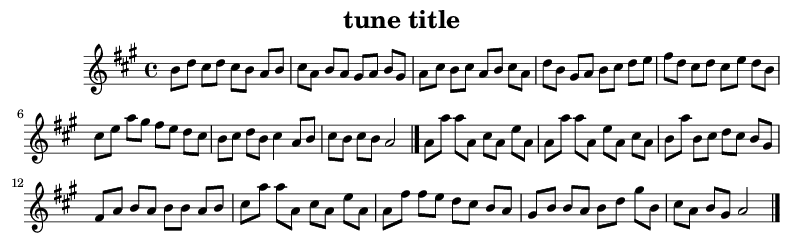


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:4/4
L:1/8
K:F#m
|: D F A F d F A F | D F A F D F A G | D F A F d F A B | G A B d c A A2 :|
 | f e f g a3 f | e c g c a c g c | f f f d a3 g |
 e f c A B c d e | f3 e f g a f | g f e g f d e c | A B d B c A B A |
 A B c A d B c B :| |


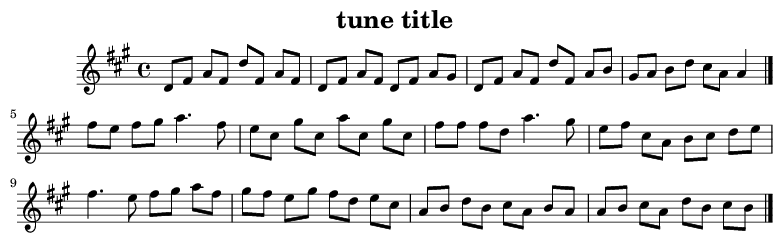


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:4/4
L:1/8
K:F#m
|: F A | B d c B F G A F | G A B G F A c A | B f g f (3 e d c d c |
 (3 B c d (3 e d c (3 B c B (3 A B c | B c d B F G A F | G B A G F c d c | (3 B c d (3 B c d c B A F |
 G2 B2 B :| |: d | (3 f g a g b f d B g |
 f e d c d c B c | d e f d B c d e | f2 d f (3 g a g f g | (3 f g a b a g f (3 e f g |
 a b a f d2 g f | (3 e f d c e d f B c | A F F B (3 A B A :|


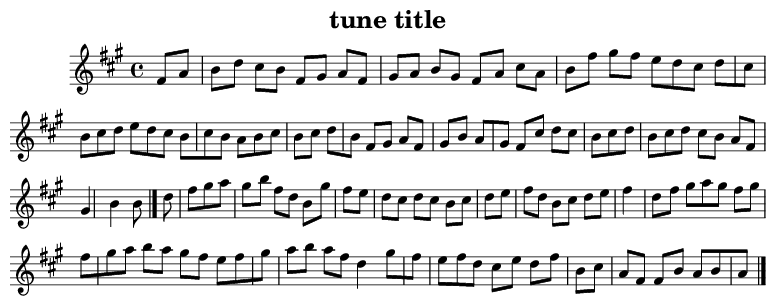


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:4/4
L:1/8
K:F#m
F > G |: A > B A > B A > F G > A | (3 F G F E > F D2 D > E | F > G A > A B2 d > e |
 f > e f > a g2 f > a | b > a g > f g2 f > g | (3 f a a d > f e2 d > B | A > F G > A B > d B > c |
 [1 d2 d2 F2 D > E :| [2 d2 f2 f2 g > g || |: a2 f2 - f > e f > g |
 a2 d2 - d A B c | d > B A > G F > E F > E | F2 E2 E2 (3 g a e | f > g f > e d > e f > g |
 a2 f2 - f > e d > c | B2 (3 c B c A2 F > G | [1 F > G A2 - A > c d > e :| [2 F > G F2 - F2 ||



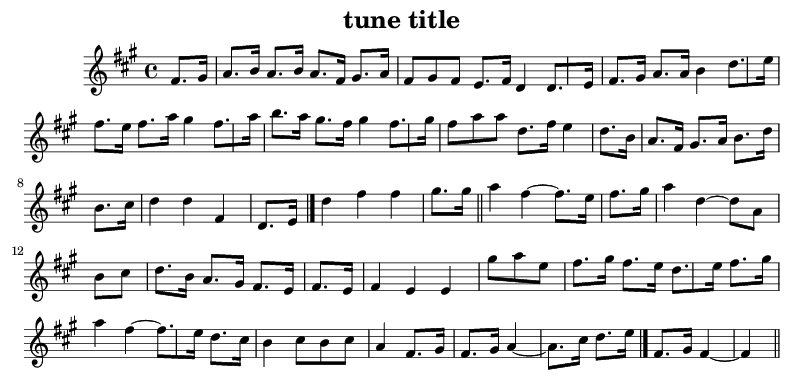


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:4/4
L:1/8
K:F#m
|: D C C A, B, G, G, B, | G, B, D E G D D B, | C B, A, C D G, G, B, | C D D C A, C E C |
 G, A, C D E G, G, G, | G, B, D E G D B, G, | C D D E D B, C A, | B, D D B, G,2 G,2 :|
 |: D E G A B c A G | D C C A, D F A C | D G G c A c B A |
 [1 G2 G A G ^F D B, G,2 :| [2 G2 G A G4 || D G F G D G B c | d g g f d B G A |
 B d c B A c F c | A B c A B G F D | D G F G D G B2 | d g f g e c c A |
 B c d B c B A F | G2 G2 G B d c | B2 A B G D B, D | G B d c B A G D |
 C D E F G A B c | d B c A B G A B | G2 D G D G F D | E F G B A F D F |
 G A (3 B c d c d A F | G2 B2 A2 A G :|


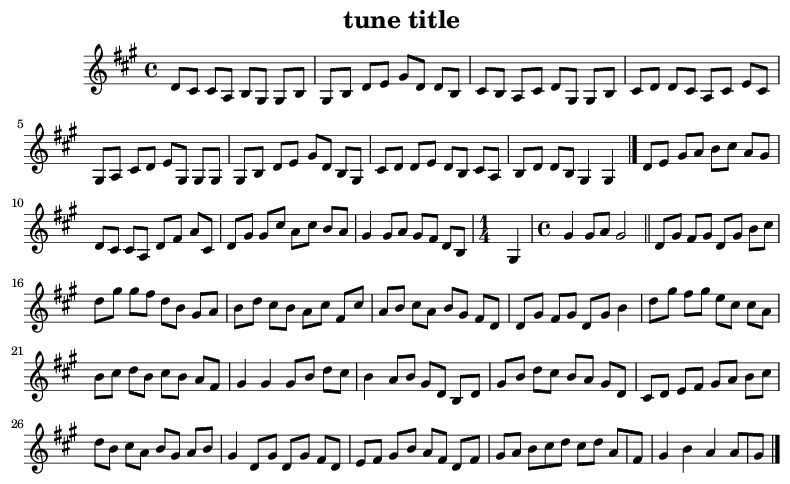


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:6/8
L:1/8
K:F#m
|: G A B A F D | A G A B2 G | A B G A G F | F D C D2 F |
 G B c A G F | A B d A G A | G F G D F G | A F D C3 :|
 |: d e f a g f | c A c f e d | c d e g f e |
 d c d c A G | A d f g a g | f d B c d e | d A G F G A |
 G F D D2 :| |: c A G A G E | c A G F G E |
 A d c A G F | D E F G A B | c G A c G E | c A G F G A |
 A d c c A B | A G F G A :|


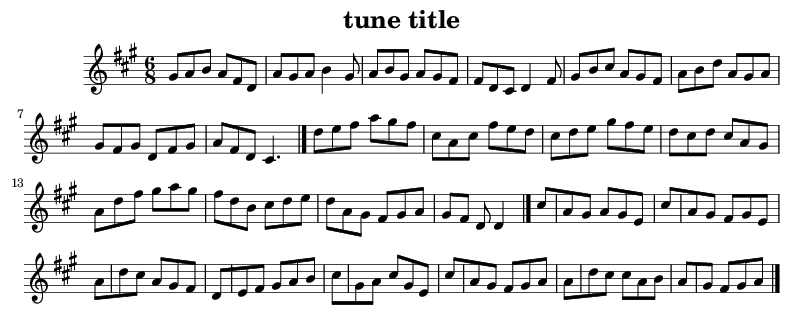


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:6/8
L:1/8
K:F#m
|: F | D E F G2 B | A B c d2 B | c G F G A B |
 c e d B B G | C D E F2 G | A B c d2 e | f d B c d c |
 A G F G2 :| |: B | A c c d c d |
 f d B c2 d | e c c g d c | d c d f e d | c d e c B c |
 A B A G2 B | c d e d c B | A G F G2 :|


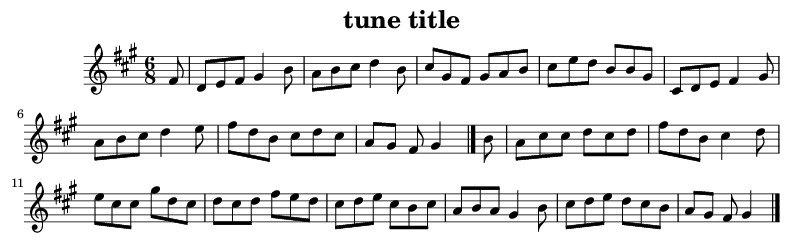


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:6/8
L:1/8
K:F#m
A |: G F G G A B | c A A B d d | c e d c B G |
 A F D D C D | G F G A F G | d c B c A F | c B A d c B |
 [1 A G F G F D :| [2 A G F G2 A || |: G A B c A G |
 F G A c d c | A B c d e f | g f d d B d | c d g e g g |
 f e d f a f | g a b c' b a | [1 g f d c d d :| [2 g a b g a b ||



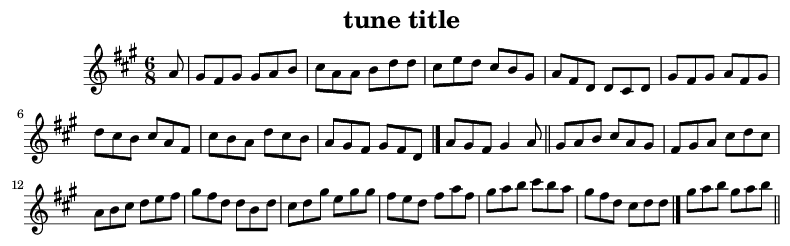


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:6/8
L:1/8
K:F#m
D | F G A c B A | G A G F A d | f e d f e f |
 e d c d2 c | F G A B c d | F G A A G F | A B c d e f |
 d B G G2 :| g | f e g f e d | f e c d c d |
 c A B c d e | d A G F2 d | f e f g e d | f e d c B A |
 c A G A B c | d e f g2 :|


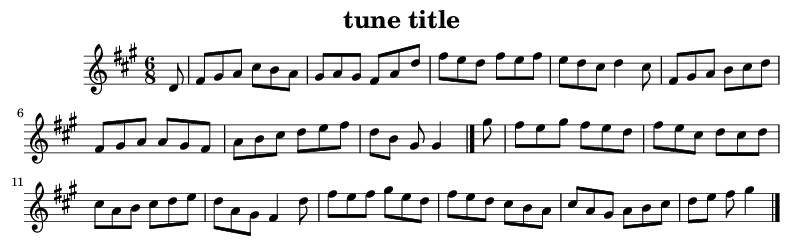


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:6/8
L:1/8
K:F#m
|: c | d f e d c B | A c F F2 E | F G A B A F |
 E G A B A B | d f e d c B | A c A F2 E | F F G A F G |
 A c c c2 :| |: B/2 c/2 | f d B F B d |
 f e c B c d | c B A F2 E | F D C B, D B | c e g f a f |
 g b f d e f | g f e c B A | G F E F2 :|


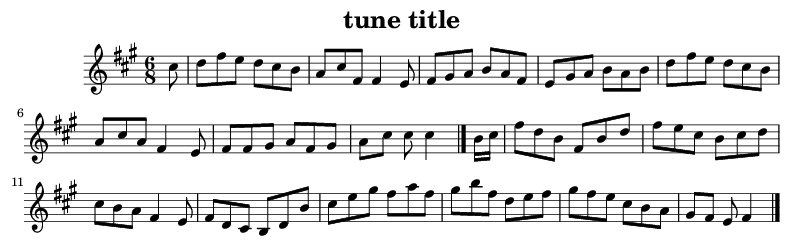


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:9/8
L:1/8
K:F#m
c d B c B A B G E | c A F c F A G E C | d c B e c A G E C | D F G A B c d e c :|
 |: c f c f c d e c e | d f c a c A d B A | c e c f d A g e c |
 B c d G F E D C D :|


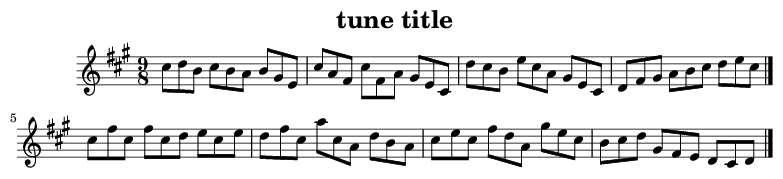


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:9/8
L:1/8
K:F#m
|: F2 A c B A B A F | E2 A c B c d2 e | f2 f f2 e d B A | [1 B2 c d B A B2 F :|
 [2 B2 d c B A F E F || |: d2 B B d c B2 B | d c B B d B c B A |
 d2 B c B B d c B | [1 A2 B d e f e2 d :| [2 A2 B d c A B2 B || |:
 d e f f e f d B A | d c e f e d e g f | f e f f e d c B A | B B A A F G A B c :|
 |: d e d B c B A F A | d e f B c d B2 A | d e d B c B A F A |
 B c d c A F D2 E :| |: B2 A A A G F2 G | A B A A B A F E D |
 B3 A G F A2 G | [1 F E F A F E D E A :| [2 F E F A F E D2 E || |:
 F E F A2 G E F E | D2 E F2 E F G A | F2 E F A B c B A | [1 B2 d d2 c d2 B :|
 [2 B2 c d A B c f e ||


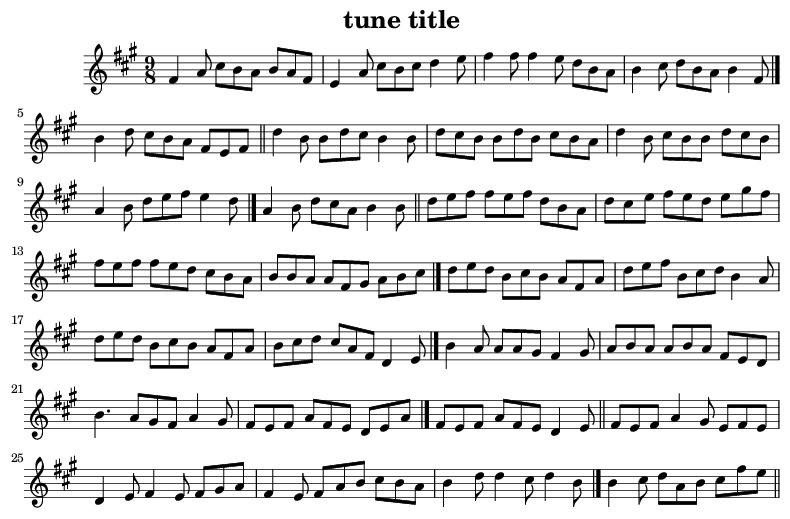


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:9/8
L:1/8
K:F#m
|: F G A c A A G F E | F E F c B A G2 E | F G A c A G F2 A | G E F G A F G F E :|
 |: c B c e d c B A G | c A B c B G A F E | c B c d c B A G F |
 B A G A G F G F E :|


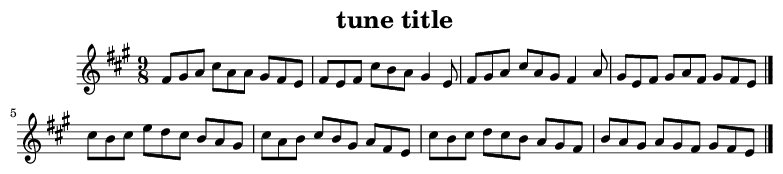


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:9/8
L:1/8
K:F#m
|: F G F D F F F G G | F E F F F D F2 F | G F G F G A B c d | A B G F G F E2 C :|
 |: d c B A F F D F A | d e d c B c A B c | d c B A2 F D F A |
 B A G F G A B2 A :| |: d c d f e c d c B | f e c d e f g f e |
 d c d g f e d c F | B A F G2 A B2 G :| |: d e d d f g f2 d |
 e f g f d B c B c | d e f d c f f2 f | g f d f e c d2 c :| |:
 B c d e c e d c B | B c d e c e f2 f | B c d e c e d c B | A c B B G E F2 F :|



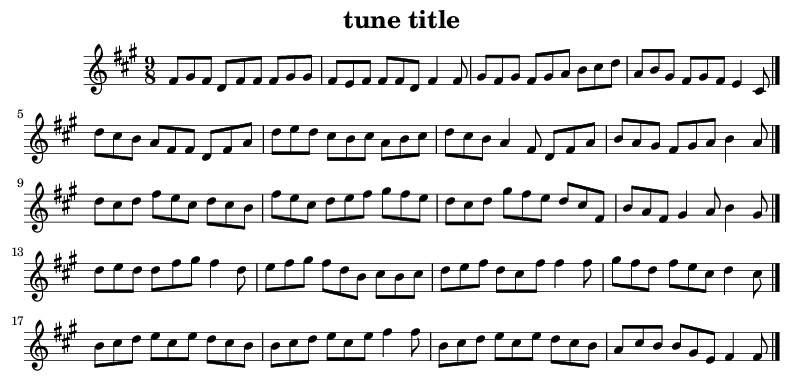


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:9/8
L:1/8
K:F#m
|: A F A c A F G A B | A F A c A A B A G | A2 F A c F A F F | A B c d B G F F E :|
 |: D E D F E D A G F | E D E F D F A F E | D E D D F E F E D |
 G F G A G F G F E :| |: d e f d e f g f e | d e f A c e g f e |
 d e d e f g f e d | e d c A B G A F E :| |


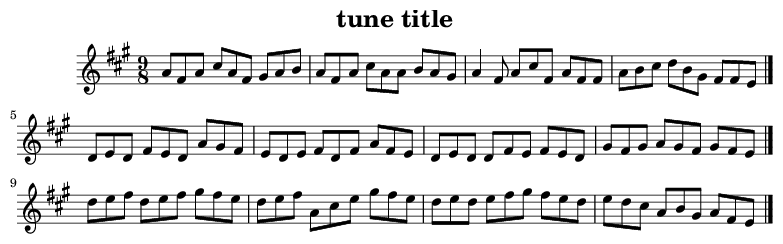


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:4/4
L:1/8
K:G
|: d > c | B > G B > G d > G B > d | c > B c > e d > B c > A | B > G B > G d > G B > d |
 c > e A > B c > e c > A | B > G B > G d > G B > d | c > A e > c d > B (3 A G F | G > B d > B e > g f > d |
 [1 e > d c > B G2 :| [2 (3 e f g d > B G2 (3 d e d || |: g > d d > B g > d e > d |
 g > B d > G B > G d > g | [1 e > c g > d d > B g > d | e > a g e a > e e > f | g > d B > G g > d e > f |
 g > G B > d g > d e > g | d > c d > B c > B A > G | (3 F G A (3 c B A G2 B > d :| [2 G > d (3 e f e d > B G > A |
 B2 G > B A > A (3 A G F | G2 e > d B > c d > B | A > G (3 F E D G2 B > c ||


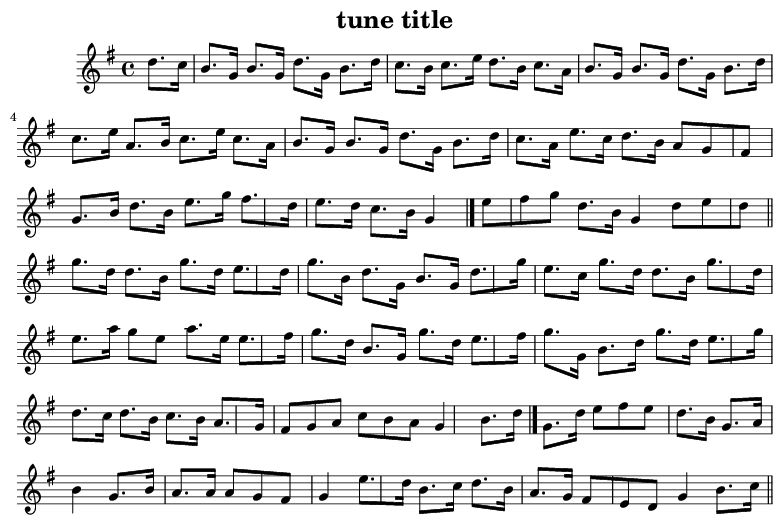


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:4/4
L:1/8
K:G
|: (3 d B G | E > G (3 E F E F < D (3 A F D | G > F G > A B < d (3 g f e | d > B A > D E < G A > B |
 (3 c A F (3 D E F (3 G F E (3 D C A, | B, > D E2 F2 (3 D G F | G > B, (3 B, G, G, D > B, D > B, | C > E A < G F > A d > c |
 B > D (3 c d c B > G :| G > d | (3 e f g (3 f g f (3 d B f (3 g f e | (3 d g f (3 e g b (3 f e d (3 c A F |
 G > B d > B (3 e f e (3 d c B | (3 c e c (3 A B A (3 G F G (3 (3 D E F (3 G A | (3 B A B (3 g f g (3 g f b (3 d g f | (3 e d g (3 b g e d > g (3 f g a |
 g < b a > g (3 g f g (3 d c B | (3 c B A (3 F G F (3 G D G (3 d B (3 (3 c B c | (3 d e d (3 B G B, (3 D G B (3 d B G | (3 C E A (3 A c A (3 E G B (3 d g f |
 (3 e d c (3 B d g (3 b a g (3 F G A | (3 B, C D (3 B A F (3 D F G (3 c G A | B2 (3 D E F (3 G B d (3 d d B | G > g (3 f e d e < g (3 g f e |
 (3 f g d (3 d e d (3 c e (3 d e d | (3 G B d (3 g b d (3 c B A F > E |


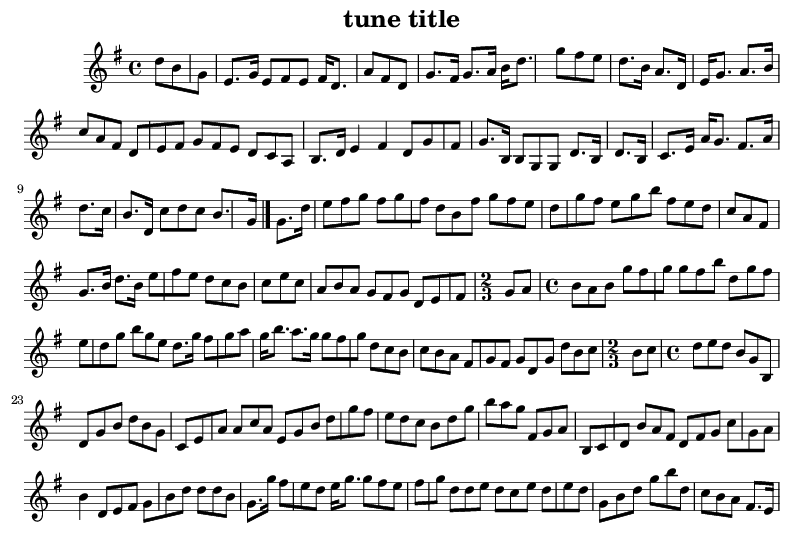


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:4/4
L:1/8
K:G
|: (3 B B B B > A G > B d > g | (3 e e e e > d B < A A > B | (3 A B B A > G B > d B > d | [1 e > f g > d B > A A > B :|
 [2 e > g f > d B < A (3 d d d || e2 e > f g2 g > g | (3 e f f (3 g f e f > d e > f | (3 g f g g > f (3 e f g e > d |
 B > A B > d e > A A > f | g > f e > g e > f g2 | a > b g > e f > d e > f | (3 e f e d > B A > B d > e |
 g > e d > B B < A A > G ||


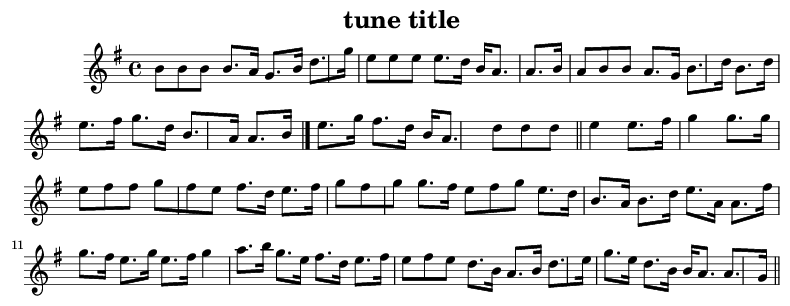


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:4/4
L:1/8
K:G
B A B G D E G A | B G d B c A A c | B G B G G E D G | E A A G A B d B |
 G A B c B A G F | G B A G E G D G | E F G A B c B A | G E A G G4 :|
 |: B G G B d e g e | d e d B G B A G | E G G E D E G A |
 G A B B A3 G | B A G B d e g e | d e c B A c B A | G E D G B G E G |
 D E G A G4 :|


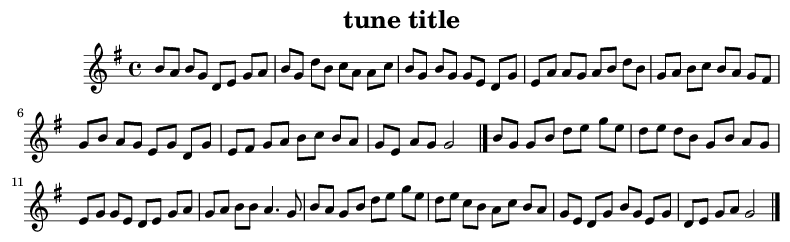


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:4/4
L:1/8
K:G
|: G A | B G A G E D D2 | E D B, D E D E A | B2 A G E D E D |
 E G G G G2 :| B d | e2 e d e2 g e | d2 d B A G A c |
 e2 e d e g e g | d B G A G2 :|


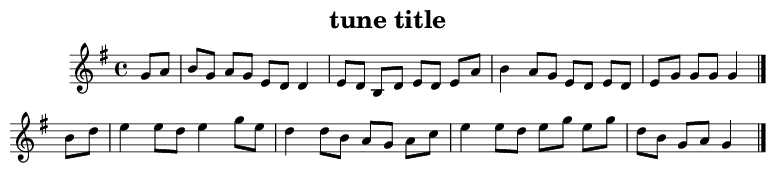


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:6/8
L:1/8
K:G
|: d c | B d B B A F | G3 B G B | A d f d A F |
 G B A G F A | B d B G B G | F3 A B c | B G B A F D |
 G3 G2 :| |: A | B3 d c B |
 c3 e c A | B3 d B G | A F D D2 c | B3 d B c |
 d3 e d c | B3 A F D | [1 G2 D D G A :| [2 G3 G B c ||
 d3 d c B | c3 e d c | B3 B G F | E A G F E D |
 G3 B c d | c B c A B c | d c A F A A | G2 G F G A |
 d3 d B c | d3 e d c | d c d c d e | d B G G A B |
 c d c B c d | c d e d c B | A G F A G F | G3 G F E ||



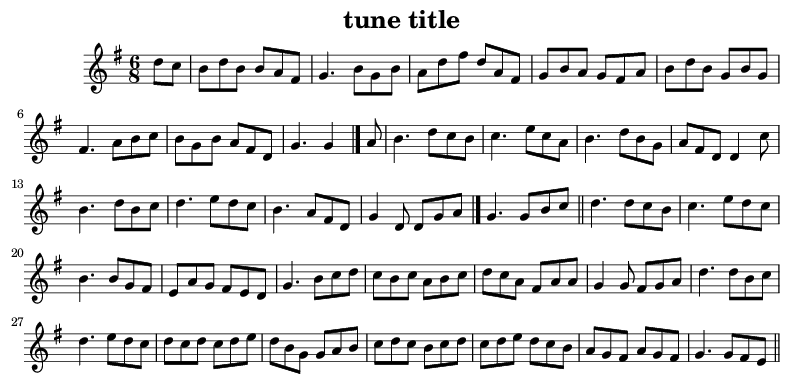


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:6/8
L:1/8
K:G
|: G B d d B G | A B c d B G | G B d e f g | d B G G A F |
 G A B d B G | A B c d B G | g f g e d B | [1 A B A G3 :|
 [2 A B A G3 :| |: e g e e g e | e g e d d d |
 e g e d e e | e f a a a b | e g e e g e | e g e d B d |
 e g e e d B | A B A G3 :| |


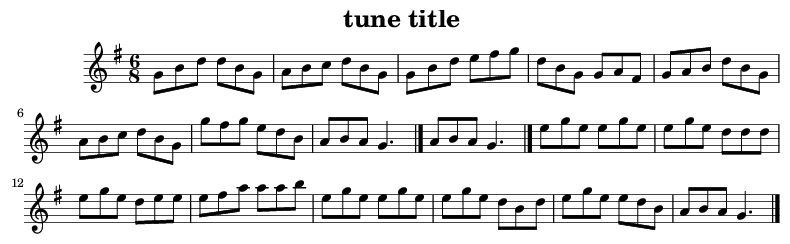


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:6/8
L:1/8
K:G
|: B | d G B A G E | d B A G2 B | d G B B A G |
 A B G E D C | D E F G A B | d g e d B G | c B A B G E |
 D F A G3 :| | |: d e |
 d c B c B A | B G E E G A | B G A B c B | A G F G A E |
 D E G A G E | D G G A G E | D B G A G E | G E F G2 :|
 |


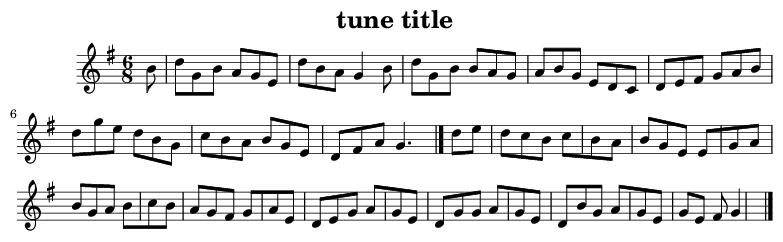


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:6/8
L:1/8
K:G
|: D E F G B d | e d B d B A | G E D B, D B | A G E E D E |
 D B, D G B d | e d B d B A | G A B D E F | [1 G E D D B, G, :|
 [2 G E ^D D B, A || d B d e f g | a f d e d ^c | d B d e f g |
 a g f e d B | d B d e f g | a f d e d B | G B d e g f |
 [1 d B G G B c :| [2 d B G G A B |]


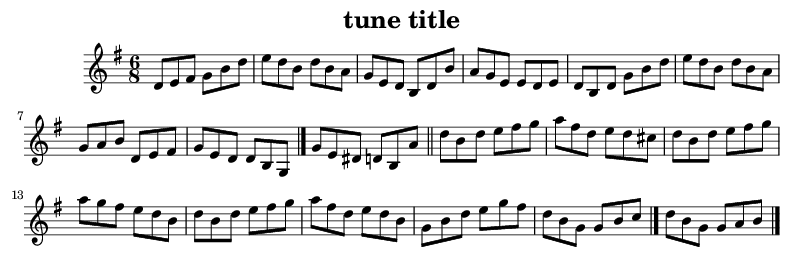


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:6/8
L:1/8
K:G
d |: B G B A G F | D E F G2 B | A B A F G A |
 B A G B d B | c e g f e d | B c d c A F | G B d c A F ||
 G G F G2 A :| [2 G3 B B B || |: d e f g3 |
 f a g f e c | d e f f b a | e f g f d c | B A B G B d |
 g d B G F G | A B c d c B | [1 A F A G2 B :| [2 A F A G B d ||
 |: g e f g b a | g b e e f d | f a g f e f |
 g e ^c d2 f | g d e g b a | g b e e f g | e f g d B A |
 [1 B G F G e f :| [2 B G F G3 ||


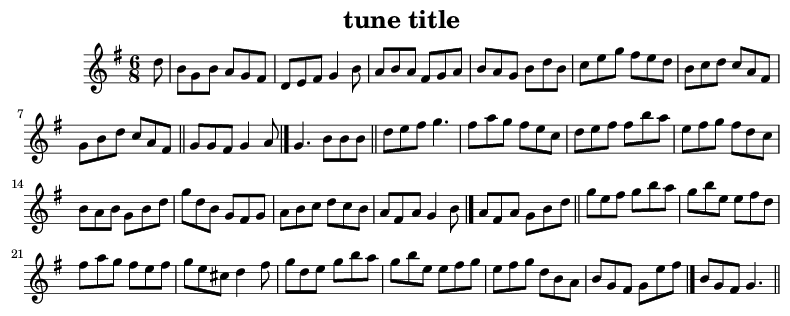


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:9/8
L:1/8
K:G
|: B2 G G2 A B2 G | c2 A A2 G A2 G | F2 E F2 D G A B | c2 A A2 G F G A :|
 |: G2 G A2 A B2 G | A2 G G2 A B2 G | A2 A A2 G A2 B |
 c2 A B2 G E2 D :|


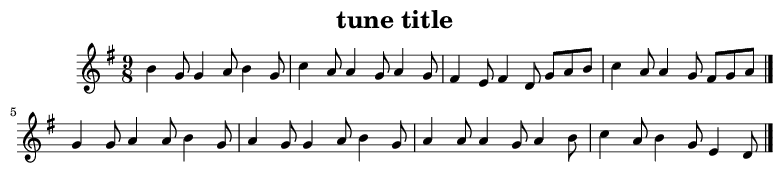


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:9/8
L:1/8
K:G
B | d > c B B > B G B > d B | d c B B > A G A2 B | d > d B c > B A B2 G |
 B < d B B > F G A2 :| d > c B B < A A B > A G | d > c B B > A B A2 B | d2 > d c > B A B2 A |
 B > c B A > G F E2 F | d < d d d > e d c > B A | A > A A A B c d2 A | d2 d d > e f e > d c |
 B > A G A > G F E2 |]


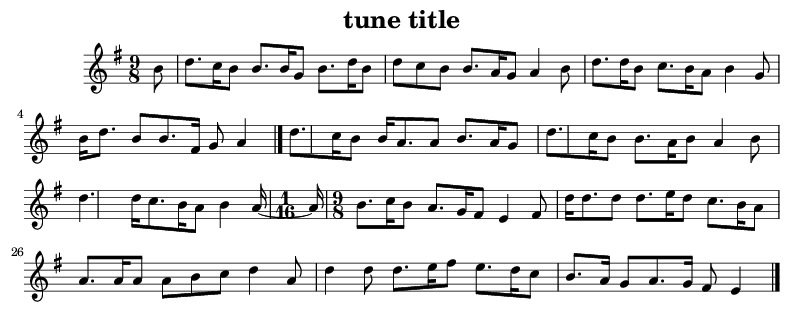


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:9/8
L:1/8
K:G
B |: d B G A c A G E D | d B G c2 c B c d | d B G c B A A F A |
 [1 G2 D D G A B c B :| [2 G2 D D B c d B G :| c2 d e f g d B G | A2 G A B A G E D |
 c2 B g2 e d B G | A B A A B c d2 G | B2 A g f e d c B | A2 A A G A B F D |
 G2 A B2 c d g e | d e c A B G A B A ||


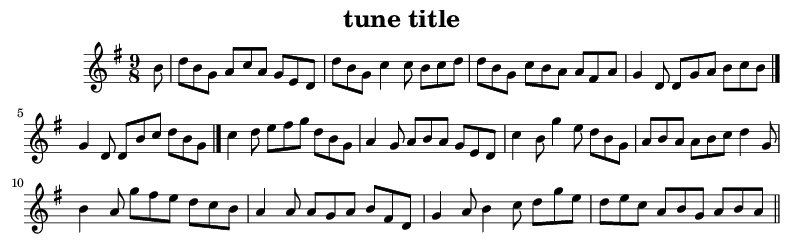


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:9/8
L:1/8
K:G
G B d | e c c c A c | c A A c A A | B G G d G B |
 c d c B G B | c c c c A B | c A A c B A | c B A B G G |
 B A A A2 z :| |: g f d e c A | G B d g f e |
 g d e e c A | B G B B A B | G B B A G B | d e f g f e |
 d e d c B A | G A F G z B :|


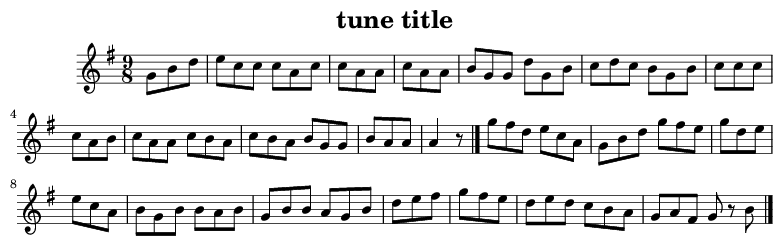


X:1
T:tune title
Z:transcription
S:source
R:rhythm
M:9/8
L:1/8
K:G
|: G2 d | d2 G G2 d G B d | g2 d G A B c A G | G2 B G2 B A G F |
 G2 G G2 B d g e :| |: g2 B B2 d g2 e | f2 d A2 e f e d |
 g2 g g f g a2 g | f e d d2 d d2 :|


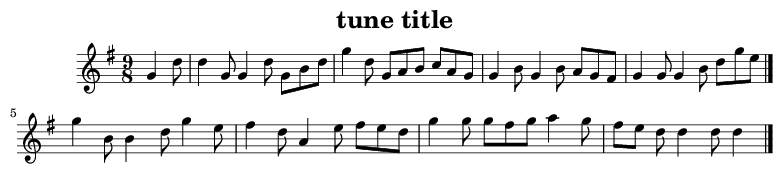

In [312]:
# https://www.abcjs.net/abcjs-editor.html
for idx, gen in enumerate(generations):
    tune_str = clean_gen(gen[:seq_lens[idx]])
    print(tune_str)
    try:
        tune = ABCTune(tune_str)
        IPython.display.display(tune.show())
    except Exception as e:
        LOGGER.warning("Tune does not compile")
        print(f"DOES NOT COMPILE. error\n{e}")
    print()

# Train on oneills

In [ ]:
# on_dataset = ABCDataset(
#     filepath='data/oneills_reformat.abc',
#     tokens=dataset.tokens
# )

In [ ]:
# print(on_dataset)

In [ ]:
# nr_unk_toks = 0
# for idx in range(len(on_dataset)):
#     nr_unk_toks += (
#         np.array(on_dataset[idx]) == on_dataset.tokenizer.unk_token_index
#     ).sum()
# nr_unk_toks

In [ ]:
# on_dataloader = DataLoader(
#     on_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     collate_fn=rpad_batch,
#     pin_memory=True,
#     num_workers=8,
# )

In [ ]:
# early_stop_callback = pl.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0.00,
#     patience=100,
#     verbose=True,
#     mode="min",
# )

In [ ]:
# lightning_trainer = pl.Trainer(gpus='0,', deterministic=True, early_stop_callback=early_stop_callback)

In [ ]:
# lightning_trainer.fit(
#     model,
#     train_dataloader=on_dataloader,
#     val_dataloaders=on_dataloader,
# )

In [ ]:
# trn, vld, tst = get_oneills_dataloaders(
#     "/disk/scratch_fast/s0816700/data/oneills/oneills_reformat.abc",
#     "/disk/scratch_fast/s0816700/data/folk-rnn/data_v3_vocabulary.txt",
#     batch_size=16,
#     num_workers=1,
#     pin_memory=True,
# )

In [ ]:
# for ii in range(len(tst.dataset)):
#     print(tst.dataset[ii])

In [ ]:
# model

In [ ]:
# print(model)
# lightning_trainer.test(
#     model,
#     test_dataloaders=tst,
# #             ckpt_path=str(args.model_load_from_checkpoint),
#     ckpt_path=None,
# )